# Agent Communication Protocol

Welcome to this Recipe!

In this recipe, we build and run agents that communicate using [Agent Communication Protocol  (ACP)](https://agentcommunicationprotocol.dev/introduction/welcome). This protocol is developed by IBM via BeeAI project under the governance of Linux foundation. This lightweight, HTTP-native protocol provides a standardized RESTful API that enables seamless multimodal communication between AI agents—regardless of their framework, language, or deployment environment.  

Key features of ACP include:
- Client-server architecture with REST interface for communication
- Flexible agent replacement even when built with different frameworks
- Offline discovery of agents
- Simple enough protocol to use with standard HTTP tools like curl, Postman, or browser requests, however Python (used in this recipe) and TypeScript SDKs are available for developer convenience
- Built primarily for asynchronous communication to handle long-running agent tasks, while fully supporting synchronous communication.

The core components of ACP are ACP Server (can host one or more agents that executes requests and returns the results to the client) and ACP Client (can be an ACP agent, application, or other service that makes requests to an ACP server).

This recipe demonstrates how Granite 3.3 model can be used to build and run agents that communicate using the ACP protocol.

## Install Dependencies

In [ ]:
! echo "::group::Install Dependencies"
%pip install uv
! uv pip install git+https://github.com/ibm-granite-community/utils.git \
    acp-sdk \
    'uvicorn<0.36.0' \
    langchain_community \
    transformers \
    sentence_transformers \
    replicate \
    colorama \
    langchain_huggingface \
    faiss-cpu \
    ddgs \
    'docling>=2.58.0' \
    'langchain_replicate @ git+https://github.com/ibm-granite-community/langchain-replicate.git'
! echo "::endgroup::"

## Wrapping agents in ACP Server

ACP supports a range of deployment architectures, including single-agent single-server, multi-agent single-server, and distributed server configurations, as outlined in the [ACP architecture documentation](https://agentcommunicationprotocol.dev/core-concepts/architecture).

In this recipe, we implement a multi-agent system hosted on a single server, comprising the following two agents:

- **RAG Agent**: This agent is initialized with a URL serving as its knowledge base. It is responsible for answering user queries related to IBM’s offerings for Wimbledon.

- **Web Search Agent**: This agent conducts a web search to identify alternative products that offer similar functionality to the one mentioned in the user’s query.

These agents are orchestrated sequentially: the RAG Agent first processes the input and generates a product-specific response, which is then passed along with the original user query to the Web Search Agent. This sequential chaining ensures that the second agent has the necessary context to perform a more targeted search, as illustrated in the diagram.



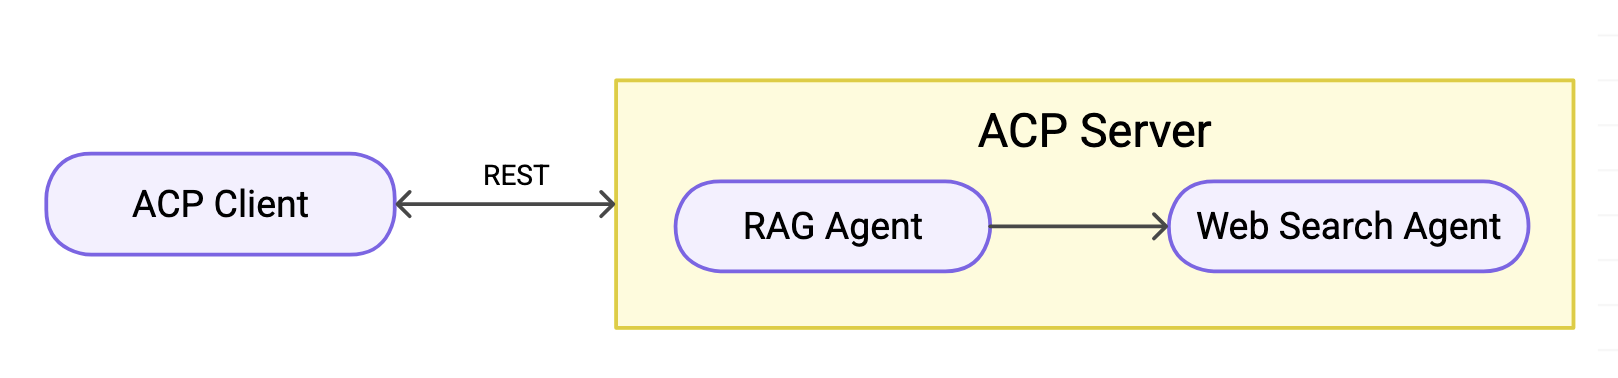


The **create_and_run_server** function is responsible for instantiating the agents and registering them within an ACP-compliant server. Once configured, the server is launched and made accessible via port 8000.

The **stop_server** function is responsible to gracefully shut down the ACP server.

**Note**: Please ensure that port 8000 is available before starting the ACP server.
- If you're running this code in Google Colab, restarting the runtime environment will typically free up the port.
- If you're running locally, make sure to terminate any process currently using port 8000. Refer to OS-specific instructions for managing ports.
Also, feel free to use other ports as you wish.

In [ ]:
from langchain_replicate import Replicate
from langchain_classic.agents import initialize_agent, AgentType
from langchain_community.vectorstores import FAISS
from langchain_classic.tools import tool
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import AutoTokenizer
from ddgs import DDGS

from ibm_granite_community.langchain.prompts import TokenizerChatPromptTemplate
from ibm_granite_community.langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_classic.chains.retrieval import create_retrieval_chain
from acp_sdk.models import Message, MessagePart
from acp_sdk.server import Context, RunYield, RunYieldResume, Server
from acp_sdk.client import Client
from ibm_granite_community.notebook_utils import get_env_var

from docling.document_converter import DocumentConverter
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.labels import DocItemLabel
from langchain_core.documents import Document
from typing import AsyncGenerator


In [ ]:

server = None

def stop_server():
    global server
    if server:
        print("Gracefully shutting down server...")
        server.should_exit = True
    else:
        print("Server is not running.")


def create_and_run_server():
    """Function to create and run the agents on ACP server"""

    global server
    server = Server()

    # Fetching the model and the tokenizer
    model_path = "ibm-granite/granite-3.3-8b-instruct"
    model = Replicate(
        model=model_path,
        replicate_api_token=get_env_var('REPLICATE_API_TOKEN'),
        model_kwargs={
        "temperature": 0.3,
        }
    )
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # RAG Agent
    @server.agent()
    async def RAG_agent(input: Message) -> AsyncGenerator[RunYield, RunYieldResume]:
        """Docling-powered RAG agent that processes a web article and answers user queries."""

        def build_vector_db_from_url(url: str):
            """Uses Docling to convert, chunk, and index a document from a URL."""

            embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
            embeddings_model = HuggingFaceEmbeddings(
                model_name=embeddings_model_path,
            )
            embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)

            converter = DocumentConverter()
            chunks = HybridChunker(tokenizer=embeddings_tokenizer).chunk(
                converter.convert(source=url).document
            )

            doc_id = 1
            docs = [
                Document(
                    page_content=chunk.text,
                    metadata={"doc_id": doc_id, "source": url}
                )
                for chunk in chunks
                if any(item.label in [DocItemLabel.TEXT, DocItemLabel.PARAGRAPH] for item in chunk.meta.doc_items)
            ]

            return FAISS.from_documents(docs, embeddings_model)

        def build_rag_agent(vectorstore):
            """Initializes the RAG agent using Docling vectorstore."""

            @tool
            def rag_tool(query: str) -> str:
                """Answers questions using RAG and the Docling vectorstore."""

                prompt_template = TokenizerChatPromptTemplate.from_template("{input}", tokenizer=tokenizer)

                combine_docs_chain = create_stuff_documents_chain(
                    llm=model,
                    prompt=prompt_template,
                )
                rag_chain = create_retrieval_chain(
                    retriever=vectorstore.as_retriever(),
                    combine_docs_chain=combine_docs_chain,
                )

                result = rag_chain.invoke({"input": query})
                return result["answer"]

            agent = initialize_agent(
                tools=[rag_tool],
                llm=model,
                agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                verbose=True,
                handle_parsing_errors=True
            )

            return agent

        # Set the source and build the RAG agent
        source_url = "https://www.ibm.com/think/news/engaging-wimbledon-fans-ibm-watsonx"
        vectorstore = build_vector_db_from_url(source_url)
        agent_executor = build_rag_agent(vectorstore)

        # Run the agent
        result = agent_executor.run(input)
        yield Message(parts=[MessagePart(content=result)])


    # Web Search Agent
    @server.agent()
    async def competitor_research_agent(input: Message, context: Context) -> AsyncGenerator[RunYield, RunYieldResume]:
        """Initializes an agent that uses a web search tool to identify similar products in the industry"""

        @tool
        def search_competitors(query: str) -> str:
            """Performs web search to identify the competitors of a given product"""

            with DDGS() as ddgs:
                search_query = f"Find competitors of the {query} in the industry."
                results = ddgs.text(search_query, region="us-en", safesearch="Moderate", max_results=5)
                if not results:
                    return "No relevant use cases found."
                formatted = ""
                for r in results:
                    formatted += f"\nTitle: {r['title']}\nURL: {r['href']}\nSnippet: {r['body']}\n"
                return formatted.strip()

        agent = initialize_agent(
            tools=[search_competitors],
            llm=model,
            agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
            verbose=True,
            handle_parsing_errors=True
        )

        prompt_string = f"""
            You are a market research analyst. Your task is to find competitors for '{input}'.
            Context on the product: {context}
            Use the `search_competitors` tool to find the competitors of the product.
            List out the top 5 competitors of the product. Do not exceed 500 words. Verify that the competitors are existing products.
            """

        prompt_template = TokenizerChatPromptTemplate.from_template(prompt_string, tokenizer=tokenizer)
        prompt = prompt_template.format(input=input, context=context)

        # Run the query and return the response
        results = agent.run(prompt)
        yield Message(parts=[MessagePart(content=results)])

    # Run the server
    print("Starting ACP server on port 8000...")
    try:
        server.run(port=8000)
    except OSError as e:
        raise e

## ACP Client

The **run_client** function establishes an asynchronous client connection to the local ACP server hosted on port 8000. It orchestrates the sequential execution of the RAG Agent followed by the Web Search Agent, ensuring that the output of the former is passed as input to the latter. The function returns the responses generated by both agents.

In [ ]:
async def run_client(query):
    """Function to run the ACP client"""
    print("Starting ACP client...")

    async with Client(base_url="http://localhost:8000") as client:
        print("Communicating with the ACP server...")

        run1 = await client.run_sync(
            agent="RAG_agent",
            input=[query]
        )

        run2 = await client.run_sync(
            agent="competitor_research_agent",
            input=[query, run1.output[0].parts[0].content]
        )

        return run1.output[0].parts[0].content, run2.output[0].parts[0].content

## ACP Server-Client Execution

This section initializes the ACP server in a background thread and introduces a 5-second delay to ensure the server is fully operational before proceeding. It then asynchronously invokes the run_client function with a query. The responses returned include both a summary generated by the RAG Agent and a competitor analysis produced by the Web Search Agent.

In [ ]:
import threading
import asyncio

# Start server in a background thread
server_thread = threading.Thread(target=create_and_run_server, daemon=True)
server_thread.start()

# Give server time to start up
print("Waiting for server to start...")
await asyncio.sleep(5)

In [ ]:
try:
    product_summary, product_competitors = await run_client("IBM's Match Chat AI assistant for Wimbledon")
except Exception as e:
    print(f"Client error: {e}")
    raise


In [ ]:
from ibm_granite_community.notebook_utils import wrap_text

print("Product Summary:\n" + wrap_text(product_summary))
print("\n\nProduct Competitors:\n" + wrap_text(product_competitors))

After successfully completing the interaction with the ACP server, we proceed to stop the server and release port 8000.

In [ ]:
stop_server()
server_thread.join()
print("Server shutdown complete.")

## Conclusion

In this recipe, we demonstrated how to build a multi-agent system using ACP and Granite models. By integrating a Retrieval-Augmented Generation (RAG) agent and a Web Search agent within a single ACP server, we showcased how agents can be composed in a sequential workflow to perform complex tasks.

With ACP, developers can seamlessly orchestrate agents across diverse tasks—whether for information retrieval, reasoning, or external tool integration using standards like Model Context Protocol—while maintaining clear interfaces and workflows. As you explore further, consider expanding to distributed deployments, incorporating additional agent types, or integrating user interfaces for real-time interactions.

## References


1. [Agent Communication Protocol](https://agentcommunicationprotocol.dev/introduction/welcome)
2. [What is Agent Communication Protocol (ACP)? - IBM Think Blog](https://www.ibm.com/think/topics/agent-communication-protocol#1509394340)
3. [DeepLearning.AI course on ACP](https://www.deeplearning.ai/short-courses/acp-agent-communication-protocol/)